In [2]:
import xarray as xr
import sys
import random
from scipy import stats
import glob
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import shapely.geometry as sgeom
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import matplotlib

%matplotlib inline

In [6]:
func = lambda x: x.split('comp_')[1].split('_{}days'.format(time_scale))[0]


In [4]:
its = 10000
DJF_bool = 'DJF'                                                          
DJF_bool = '_{}only'.format(DJF_bool) 
cesta_root = '/mnt/nas4.meop2/meop40.data.model/CMAM/0A.daily/'
cesta = f'{cesta_root}composites_woSSW{DJF_bool}/'
print(cesta)
time_scale = '20'
lw = 2
comp_name_ls = ['himalayas', 'eastasia', 'westamer',]
size_dict = {'20': [45,74,36], '30': [38,66,35]}
line_width = 5
box = sgeom.box(minx=70, maxx=105, miny=20, maxy=42)
box2 = sgeom.box(minx=110, maxx=145, miny=30, maxy=48)
box3 = sgeom.box(minx=-125, maxx=-102.5, miny=27.5, maxy=52)
boxes = [box, box2, box3]
projection = ccrs.PlateCarree(central_longitude=0)#Robinson()# Orthographic(180, 90)
proj_str = str(projection).split('crs.')[1].split(' object')[0]

/mnt/nas4.meop2/meop40.data.model/CMAM/0A.daily/composites_woSSW_DJFonly/


In [7]:
var = 'accelogw'
ch_lev = 7000
what = 'absolute'
scale = 3600*24
if var.lower() in ['lwa']:
    lev_sys_fo = 'logH/'
    lev_sys_fi = '_logH'
    sel_dict = dict(z = ch_lev)
    units = 'm'

else:                                                           
    lev_sys_fo = ''
    lev_sys_fi = ''
    sel_dict = dict(plev = ch_lev)
    units = 'Pa'

    
outfile_name = '{}{}{}_pvalues_from{}_comp_*_{}days@{}Pa.nc'.format(cesta, var, lev_sys_fi, its, time_scale, ch_lev)
print(outfile_name)
outfile_name_ls = glob.glob(outfile_name)
#ds_pv = xr.open_mfdataset(outfile_name_ls, concat_dim='e_type')
#ds_pv['e_type'] = list(map(func, outfile_name_ls))

comp_file = '{}{}{}_{}_comp_*_{}days.nc'.format(cesta, var, lev_sys_fi, what, time_scale)
comp_file_ls = glob.glob(comp_file)
ds_comp = xr.open_mfdataset(comp_file_ls, combine='nested', concat_dim='e_type')
ds_comp['e_type'] = list(map(func, comp_file_ls))
ds_comp = ds_comp.sel(**sel_dict).sel(lag = 0)*scale
ds_comp[var].attrs['units'] = r'm/s/day'
ds_comp[var].attrs['long_name'] = r'OGWD'

comp_file = f'{cesta_root}/{var}/{lev_sys_fo}{var}_climatology_woSSW.nc'
print(comp_file)
sel_dict['month'] = [12, 1, 2]
ds_comp2 = xr.open_dataset(comp_file).sel(**sel_dict).mean('month')[var]*scale
ds_comp2

/mnt/nas4.meop2/meop40.data.model/CMAM/0A.daily/composites_woSSW_DJFonly/accelogw_pvalues_from10000_comp_*_20days@7000Pa.nc
/mnt/nas4.meop2/meop40.data.model/CMAM/0A.daily//accelogw/accelogw_climatology_woSSW.nc


<xarray.DataArray 'accelogw' (lat: 48, lon: 96)>
array([[ 1.27566129e-04,  1.70641983e-03, -1.94010744e-02, ...,
        -2.70996527e-03, -3.74694500e-03, -4.19056627e-03],
       [-1.95671484e-03, -2.81427072e-02, -2.41635886e-02, ...,
        -1.36615042e-02, -2.98721307e-02, -5.87683020e-02],
       [-9.25233566e-03, -2.31135550e-02, -2.46926693e-02, ...,
        -2.93053920e-02, -6.71913113e-03, -5.59148125e-02],
       ...,
       [ 3.82361029e-05,  3.95597657e-04, -2.97574831e-02, ...,
        -3.81287287e-03, -1.78857747e-04,  1.32959757e-05],
       [ 1.86226394e-10,  1.88774128e-10,  1.99590372e-10, ...,
        -6.98628730e-03, -1.85505028e-04, -1.74460414e-05],
       [ 1.86735253e-10,  1.89487437e-10,  1.82728258e-10, ...,
         1.93226530e-10,  1.89837239e-10,  1.89837239e-10]])
Coordinates:
    plev     float64 7e+03
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2

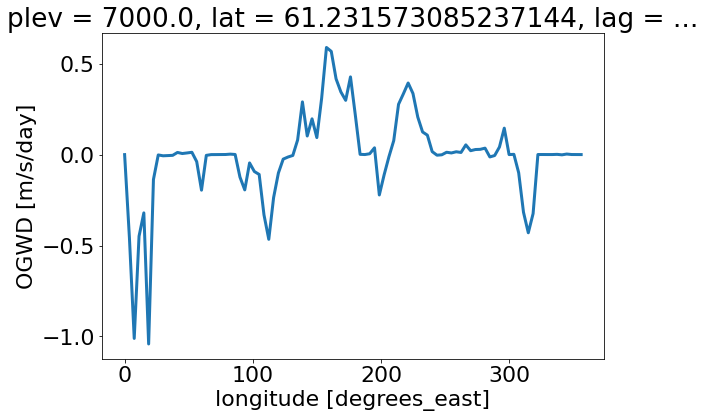

In [9]:
plt.rcParams.update({'font.size': 22})

ds_comp[var].sel(e_type = 'westamer').sel(lat = 60, method='nearest').plot(size = 6, lw = 3)

accelogw@7000Pa_absolute_allwclim_20days_PlateCarree__DJFonly.pdf


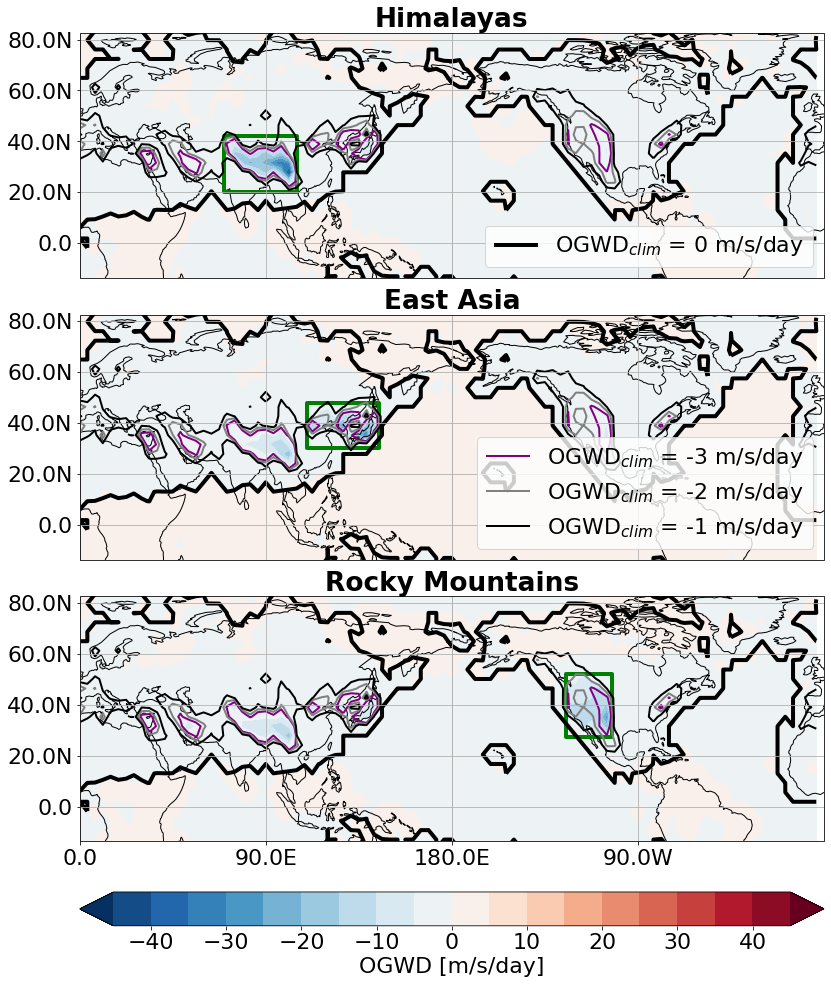

In [11]:
projection = ccrs.PlateCarree(central_longitude=180)
title_ls = ['Himalayas', 'East Asia', 'Rocky Mountains']
p = (ds_comp[var].sel(e_type = comp_name_ls)).plot.contourf(col = 'e_type', levels = 21, robust = False, \
                                                          col_wrap = 1, \
                                                          transform=ccrs.PlateCarree(), \
                                                          aspect=ds_comp.dims['lon']/ds_comp.dims['lat'], \
                                                          size = 5, \
                                                          extend = 'both', \
                                                          subplot_kws={'projection': projection}, \
                                                          cbar_kwargs = {'orientation': 'horizontal', \
                                                                         'pad': 0.05})

fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()

for i,(ax, sel_dict, box) in enumerate(zip(p.axes.flat, p.name_dicts.flat, boxes)):
    ax.coastlines()
    ax.gridlines(xlocs = [-180, -90, 0, 90, 180])
    ax.set_yticks([0, 20, 40, 60, 80], crs=ccrs.PlateCarree())
    lat_formatter = LatitudeFormatter(number_format='.1f', \
                                      degree_symbol='')        
    ax.yaxis.set_major_formatter(lat_formatter)

    if i == 2:
        ax.set_xticks([-90, 0, 90, 180], crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.1f', \
                                       degree_symbol='', \
                                       dateline_direction_label=True)    
        ax.xaxis.set_major_formatter(lon_formatter)
        
    
    CS = (ds_comp2).plot.contour(levels = [-3,-2,-1], \
                                    colors =['purple','gray','k'], \
                                     ax = ax, linewidths = lw, \
                                     transform=ccrs.PlateCarree())
    if i == 1: 
        labels = [r"OGWD$_{clim}$ = -3 m/s/day", 
                  r"OGWD$_{clim}$ = -2 m/s/day", 
                  r"OGWD$_{clim}$ = -1 m/s/day"]
        for j in range(len(labels)):
            CS.collections[j].set_label(labels[j])

        ax.legend(loc='lower right')

    #plt.legend(proxy, )
        
    #plt.clabel(CS, inline=1, fontsize=14)
   
    CS = ds_comp2.plot.contour(levels = [0], colors = 'k', \
                                                ax = ax, linewidths = lw*2, \
                                                transform=ccrs.PlateCarree())
    if i == 0: 
        labels = [r"OGWD$_{clim}$ = 0 m/s/day"]
        for j in range(len(labels)):
            CS.collections[j].set_label(labels[j])

        ax.legend(loc='lower right')

    #, fmt = fmt)

    if proj_str == 'PlateCarree':
        ax.set_extent([0, 270, -10, 80])#ax.set_extent([-180, 180, -10, 80])
        ax.set_aspect('auto')

    plot_kwargs2 = dict(levels = [0,0.05], hatches=['\\\\',None], \
                                colors='none', add_colorbar=False, transform=ccrs.PlateCarree())
    #temp = ds_pv[var].sel(**sel_dict)#*24*3600

    #temp.plot.contourf(ax = ax, **plot_kwargs2)
    plot_kwargs2['levels'] = [0,0.01]
    plot_kwargs2['hatches'] = ['////',None]

    #temp.plot.contourf(ax = ax, **plot_kwargs2) #ax.contourf(temp.lon, temp.lat, temp.values, **plot_kwargs2)
    ax.set_title(title_ls[i], fontdict = dict(fontweight = 'bold')) # sel_dict['e_type']
    ax.add_geometries([box], ccrs.PlateCarree(), \
                      facecolor=['none'], edgecolor=['green'], \
                      linewidth = [4])

    
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    
out_fig = f'{var}@{ch_lev}{units}_{what}_allwclim_{time_scale}days_{proj_str}_{DJF_bool}.pdf'
print(out_fig)
#plt.savefig(out_fig, bbox_inches='tight')